<a href="https://colab.research.google.com/github/soumik12345/enhance-me/blob/mirnet/notebooks/enhance_me_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/soumik12345/enhance-me -b mirnet
!pip install wandb streamlit

Cloning into 'enhance-me'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 47 (delta 15), reused 38 (delta 9), pack-reused 0
Unpacking objects: 100% (47/47), done.
     |████████████████████████████████| 1.7 MB 4.3 MB/s 
     |████████████████████████████████| 9.1 MB 77.0 MB/s 
     |████████████████████████████████| 180 kB 73.4 MB/s 
     |████████████████████████████████| 140 kB 63.0 MB/s 
     |████████████████████████████████| 97 kB 8.4 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 4.3 MB 62.7 MB/s 
     |████████████████████████████████| 76 kB 6.1 MB/s 
     |████████████████████████████████| 111 kB 90.2 MB/s 
     |████████████████████████████████| 178 kB 67.9 MB/s 
     |████████████████████████████████| 125 kB 87.4 MB/s 
     |████████████████████████████████| 791 kB 70.3 MB/s 
     |████████████████████████████████| 374 k

In [ ]:
import sys
sys.path.append("./enhance-me")

from PIL import Image
from enhance_me import commons
from enhance_me.mirnet import MIRNet

In [ ]:
#@title MIRNet Train Configs

experiment_name = 'lol_dataset_128' #@param {type:"string"}
image_size = 128 #@param {type:"integer"}
dataset_label = 'lol' #@param ["lol"]
apply_random_horizontal_flip = True #@param {type:"boolean"}
apply_random_vertical_flip = True #@param {type:"boolean"}
apply_random_rotation = True #@param {type:"boolean"}
wandb_api_key = '' #@param {type:"string"}
val_split = 0.1 #@param {type:"slider", min:0.1, max:1.0, step:0.1}
batch_size = 4 #@param {type:"integer"}
num_recursive_residual_groups = 3 #@param {type:"slider", min:1, max:5, step:1}
num_multi_scale_residual_blocks = 2 #@param {type:"slider", min:1, max:5, step:1}
learning_rate = 1e-4 #@param {type:"number"}
epsilon = 1e-3 #@param {type:"number"}
epochs = 50 #@param {type:"slider", min:10, max:100, step:5}

In [ ]:
mirnet = MIRNet(
    experiment_name=experiment_name,
    image_size=image_size,
    dataset_label=dataset_label,
    val_split=val_split,
    batch_size=batch_size,
    apply_random_horizontal_flip=apply_random_horizontal_flip,
    apply_random_vertical_flip=apply_random_vertical_flip,
    apply_random_rotation=apply_random_rotation,
    wandb_api_key=None if wandb_api_key == '' else wandb_api_key
)

Number of train data points: 436
Number of validation data points: 49


2021-11-27 07:33:47.257936: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
wandb: Currently logged in as: 19soumik-rakshit96 (use `wandb login --relogin` to force relogin)


In [ ]:
mirnet.build_model(
    num_recursive_residual_groups=num_recursive_residual_groups,
    num_multi_scale_residual_blocks=num_multi_scale_residual_blocks,
    learning_rate=learning_rate,
    epsilon=epsilon
)

In [ ]:
history = mirnet.train(epochs=epochs)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/50
109/109 [==============================] - 123s 720ms/step - loss: 0.1782 - peak_signal_noise_ratio: 63.1665 - val_loss: 0.1806 - val_peak_signal_noise_ratio: 63.7517 - lr: 1.0000e-04
Epoch 2/50
109/109 [==============================] - 74s 680ms/step - loss: 0.1630 - peak_signal_noise_ratio: 63.9581 - val_loss: 0.1783 - val_peak_signal_noise_ratio: 63.4445 - lr: 1.0000e-04
Epoch 3/50
109/109 [==============================] - 73s 673ms/step - loss: 0.1634 - peak_signal_noise_ratio: 64.0140 - val_loss: 0.1554 - val_peak_signal_noise_ratio: 64.8055 - lr: 1.0000e-04
Epoch 4/50
109/109 [==============================] - 74s 679ms/step - loss: 0.1636 - peak_signal_noise_ratio: 63.9317 - val_loss: 0.1443 - val_peak_signal_noise_ratio: 65.2426 - lr: 1.0000e-04
Epoch 5/50
109/109 [==============================] - 69s 633ms/step - loss: 0.1587 - peak_signal_noise_ratio: 64.2932 - val_loss: 0.1624 - val_peak_signal_noise_ratio: 64.7747 - lr: 1.0000e-04
Epoch 6/50
109/109 [=========

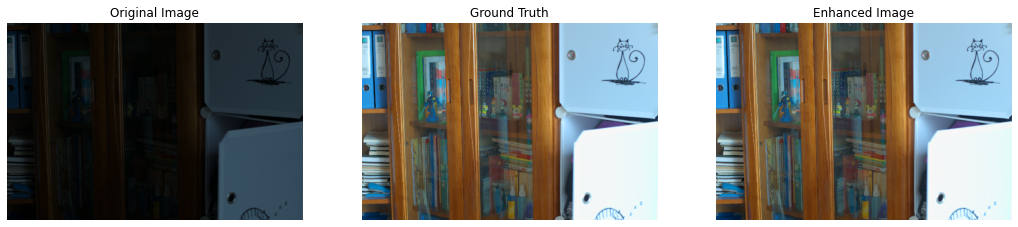

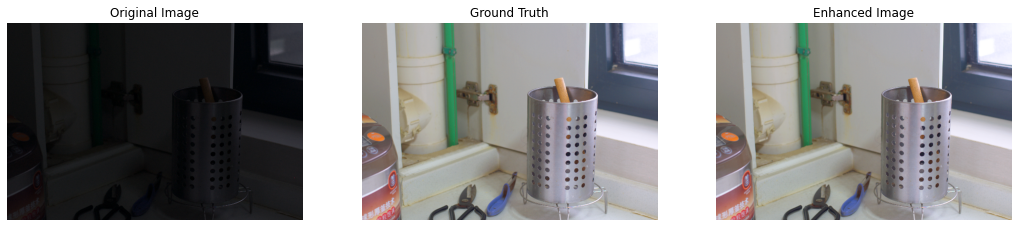

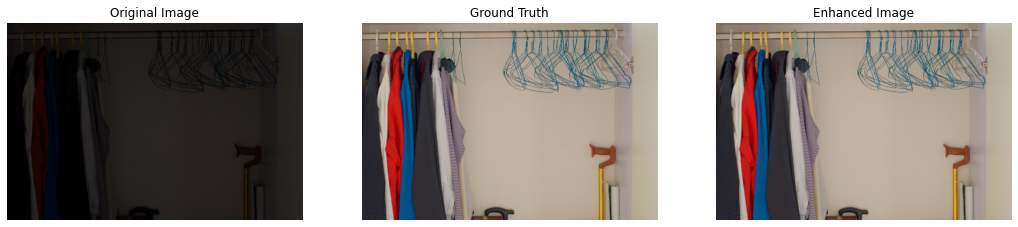

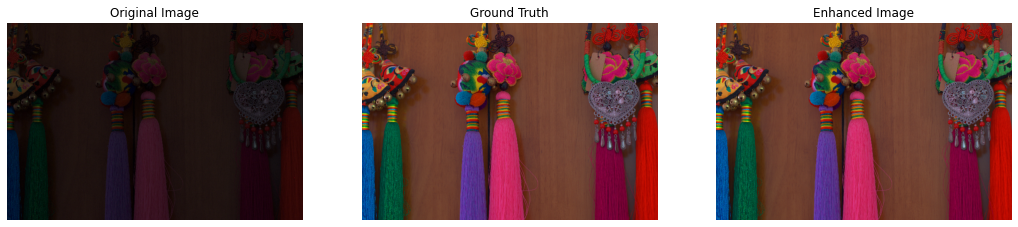

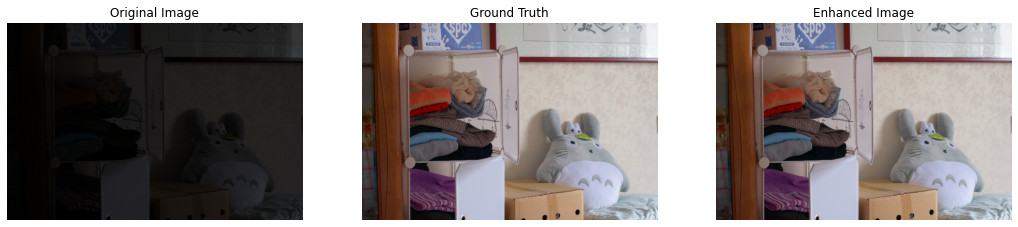

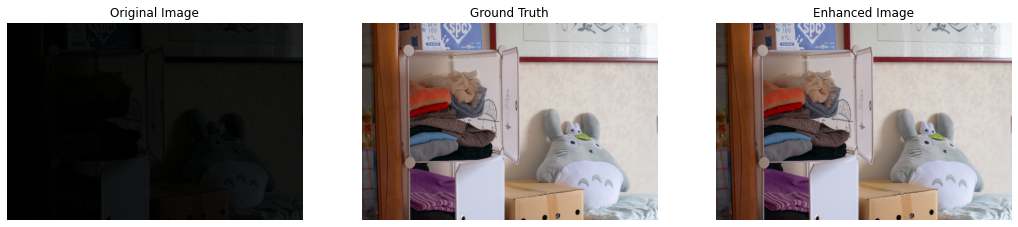

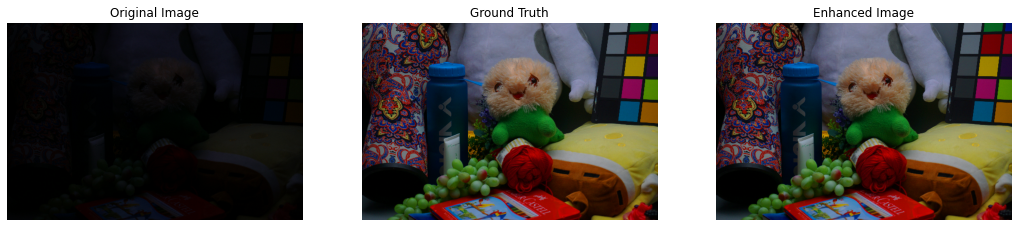

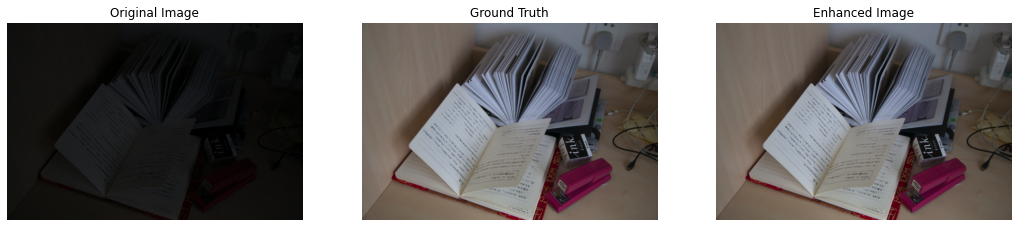

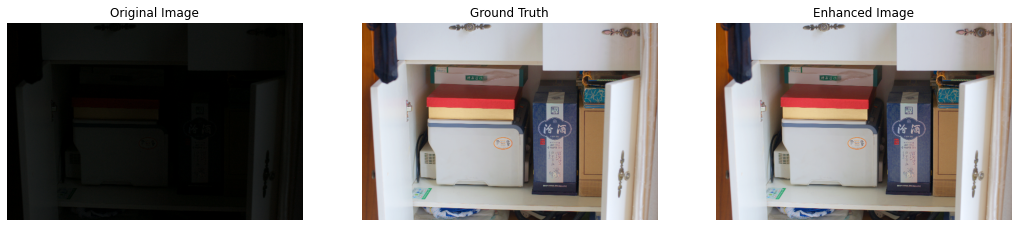

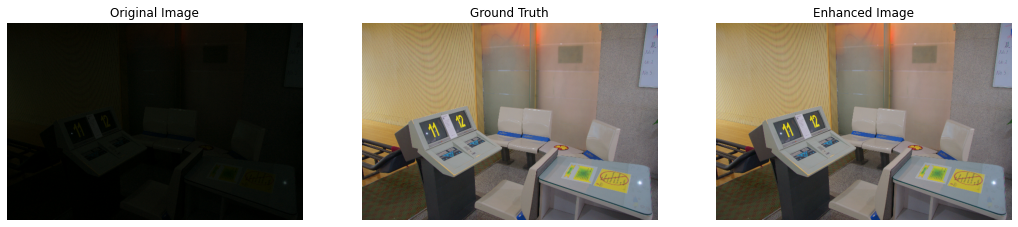

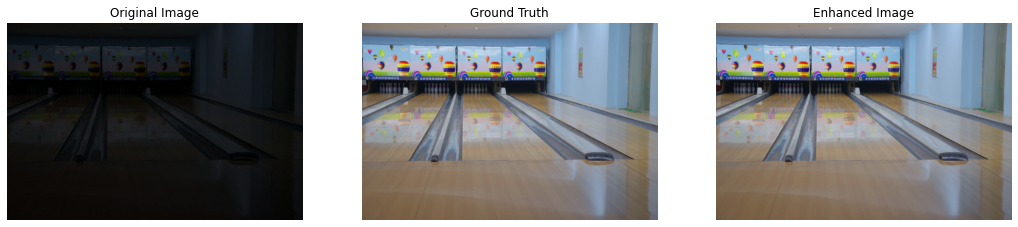

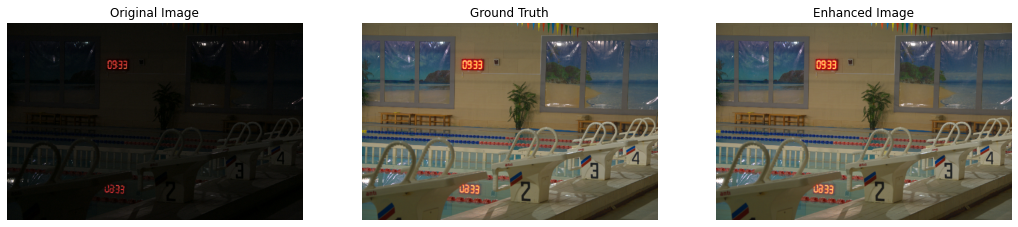

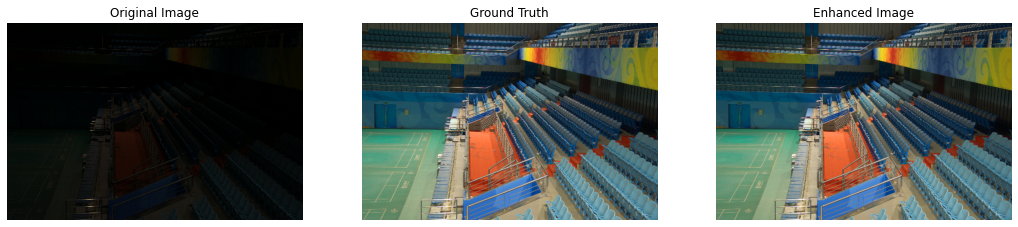

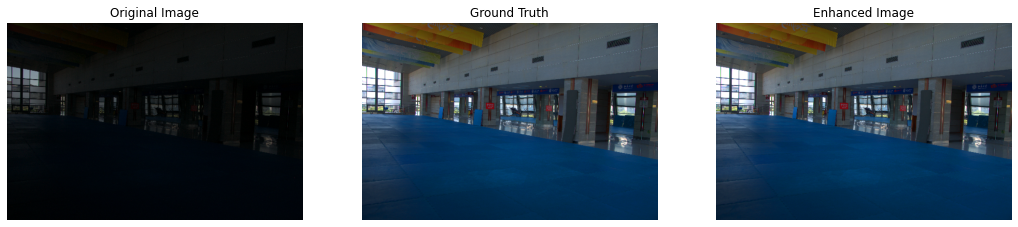

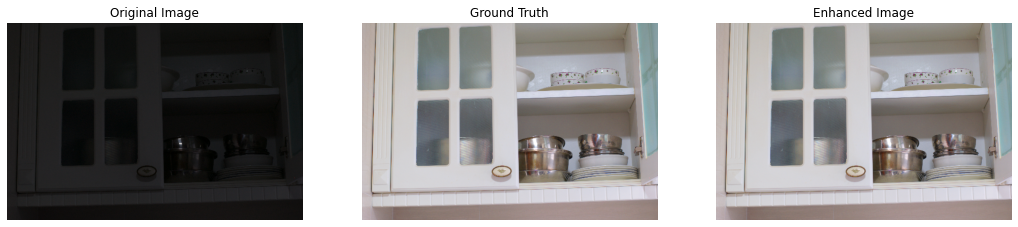

In [ ]:
for index, low_image_file in enumerate(mirnet.test_low_images):
    original_image = Image.open(low_image_file)
    enhanced_image = mirnet.infer(original_image)
    ground_truth = Image.open(mirnet.test_enhanced_images[index])
    commons.plot_results(
        [original_image, ground_truth, ground_truth],
        ["Original Image", "Ground Truth", "Enhanced Image"],
        (18, 18)
    )